<div dir="rtl" style="margin:auto; width:90%; font-family:vazirmatn;">
<ol><li><p><strong>زمان ایجاد سرویس‌ها:</strong></p><ul><li>هر زمان که کانتینر DI به درخواست یک سرویس خاص مانند <code>IMessageSender</code> پاسخ می‌دهد، دو گزینه دارد:<ol><li>یک نمونه جدید از سرویس ایجاد کند و آن را بازگرداند.</li><li>یک نمونه موجود از سرویس را بازگرداند که قبلاً ایجاد شده است.</li></ol></li></ul></li><li><p><strong>تعیین رفتار کانتینر DI:</strong></p><ul><li><strong>طول عمر سرویس</strong> رفتار کانتینر DI را در قبال این دو گزینه کنترل می‌کند. طول عمر مشخص می‌کند که کانتینر چه زمانی باید از نمونه‌های موجود سرویس استفاده کند و چه زمانی باید یک نمونه جدید ایجاد کند.</li></ul></li><li><p><strong>تعریف طول عمر سرویس:</strong></p><ul><li><strong>طول عمر یک سرویس</strong> مدت زمانی است که یک نمونه از سرویس در کانتینر زندگی می‌کند، قبل از اینکه کانتینر نیاز به ایجاد یک نمونه جدید از آن داشته باشد.</li></ul></li></ol>

<h5> سه نوع طول عمر سرویس‌ها:</h5>
<ol><li><p><strong>Transient:</strong></p><ul><li><strong>تعریف:</strong> هر بار که یک سرویس با طول عمر Transient درخواست شود، یک نمونه جدید از آن سرویس ایجاد می‌شود.</li><li><strong>نکته:</strong> این به این معنی است که ممکن است در یک گراف وابستگی (Dependency Graph) چندین نمونه متفاوت از یک کلاس وجود داشته باشد، حتی اگر آن کلاس به عنوان یک سرویس واحد ثبت شده باشد.</li><li><strong>مثال:</strong> اگر در یک درخواست خاص چندین بار به یک سرویس <code>Transient</code> نیاز داشته باشید، هر بار یک نمونه جدید از آن سرویس ساخته خواهد شد.</li></ul></li><li><p><strong>Scoped:</strong></p><ul><li><strong>تعریف:</strong> در طول یک <strong>Scope</strong> (که معمولاً به طول یک درخواست وب در ASP.NET Core مربوط می‌شود)، تمام درخواست‌ها برای یک سرویس مشخص، همان شیء را برمی‌گردانند.</li><li><strong>نکته:</strong> در ASP.NET Core، هر درخواست وب (HTTP request) یک Scope جدید ایجاد می‌کند. بنابراین، در طول مدت زمان یک درخواست وب، سرویس‌های <code>Scoped</code> مشابه یکدیگر هستند، اما برای درخواست‌های دیگر، یک نمونه جدید از سرویس ایجاد می‌شود.</li><li><strong>مثال:</strong> اگر یک سرویس <code>Scoped</code> در یک درخواست وب تزریق شود و چندین بار استفاده شود، هر بار همان نمونه برگردانده می‌شود.</li></ul></li><li><p><strong>Singleton:</strong></p><ul><li><strong>تعریف:</strong> یک سرویس <code>Singleton</code> در طول عمر کل برنامه (Application lifetime) فقط یکبار ایجاد می‌شود و همیشه همان نمونه بازگردانده می‌شود، صرف‌نظر از Scope.</li><li><strong>نکته:</strong> این نوع سرویس در سراسر برنامه ثابت است و می‌تواند در کل برنامه به اشتراک گذاشته شود. از آنجایی که فقط یک نمونه از آن وجود دارد، برای ذخیره اطلاعات مشترک یا انجام کارهایی که نیاز به اشتراک داده‌ها در سراسر برنامه دارند، مناسب است.</li><li><strong>مثال:</strong> اگر یک سرویس <code>Singleton</code> ثبت کنید، اولین باری که آن سرویس درخواست می‌شود، ایجاد می‌شود و پس از آن همان نمونه در تمام درخواست‌های بعدی استفاده می‌شود.</li></ul></li></ol>
</div>

In [ ]:
WebApplicationBuilder builder = WebApplication.CreateBuilder(args);

var app = builder.Build();

app.MapGet("/", RowCounts);

app.Run();

static string RowCounts(
	DataContext db,
	Repository repository)
{
	int dbCount = db.RowCount;
	int repositoryCount = repository.RowCount;
	return $"DataContext: {dbCount}, Repository: {repositoryCount}";
}

internal class DataContext
{
	public int RowCount { get; }
		= Random.Shared.Next(1, 1_000_000_000);
}

internal class Repository
{
	private readonly DataContext _dataContext;

	public Repository(DataContext dataContext)
	{
		_dataContext = dataContext;
	}

	public int RowCount => _dataContext.RowCount;
}



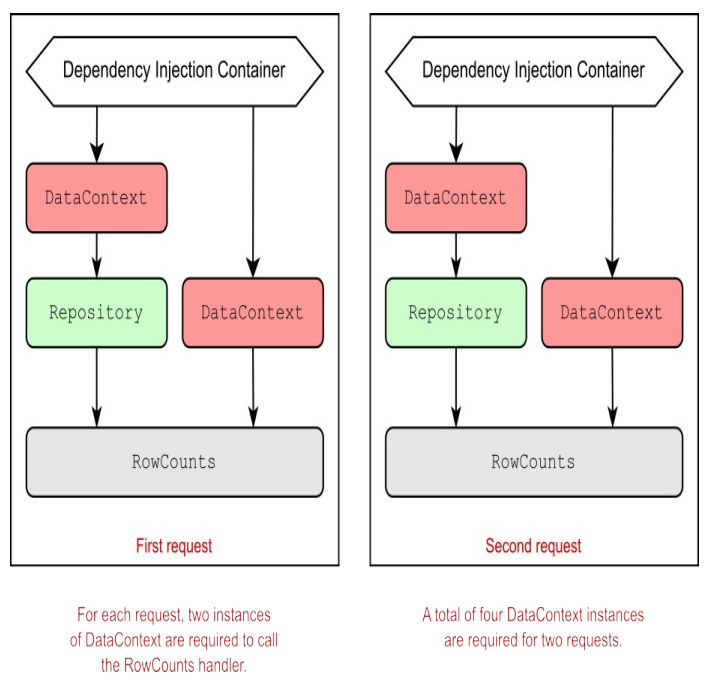

### Transient: Everyone is unique

In [ ]:
builder.Services.AddTransient<DataContext>();
builder.Services.AddTransient<Repository>();

When you register services this way, ***every time a dependency is required***, the
**container** `creates a new one`.  
the `DataContext` injected into the `Repository` will be a ***different instance*** from the ***one injected*** into the `RowCounts handler`

### Scoped: Let’s stick together

In [ ]:
builder.Services.AddScoped<DataContext>();
builder.Services.AddScoped<Repository>();

The `DataContext` injected into the ***Repository*** is the `same instance` as the one injected into the ***RowCounts handler***.  
  
In the ***next request***, you’re in a ***different scope***, so the container ***creates a new instance*** of `DataContext`

Due to the ***nature of web requests***, you’ll often find services registered as
`scoped` dependencies in ***ASP.NET Core***.  
  
`Database contexts` and `authentication` services are ***common examples*** of services that should be `scoped` to a request

<div dir="rtl" style="margin:auto; width:90%; font-family:vazirmatn;">

<h5>اصول و راهنماها برای انتخاب <code>Scoped</code> یا <code>Transient</code>:</h5>
<ol><li><p><strong>اگر سرویس به داده‌های مرتبط با درخواست کاربر وابسته است:</strong></p><ul><li><strong><code>Scoped</code>:</strong> اگر سرویس به داده‌های مرتبط با درخواست کاربر (مثل اطلاعات کاربر، اعتبارسنجی، یا داده‌های مرتبط با درخواست خاصی از دیتابیس) وابسته است، معمولاً بهتر است آن را به صورت <code>Scoped</code> تعریف کنید. این کار تضمین می‌کند که در طول یک درخواست، همان نمونه سرویس استفاده می‌شود و داده‌ها در طول درخواست مشترک باقی می‌مانند.</li><li><strong>مثال:</strong> سرویس‌هایی که به اطلاعات کاربران فعلی نیاز دارند، مانند سرویس‌های مدیریت سبد خرید یا سرویس‌هایی که با <code>HttpContext</code> کار می‌کنند.</li></ul></li><li><p><strong>اگر سرویس باید بدون حفظ حالت (Stateless) باشد:</strong></p><ul><li><strong><code>Transient</code>:</strong> اگر سرویس به شکلی طراحی شده است که هیچ اطلاعاتی را در خود نگه نمی‌دارد (Stateless) و باید هر بار یک نمونه جدید از آن ساخته شود، بهتر است از <code>Transient</code> استفاده کنید. سرویس‌هایی که منطق محاسباتی یا پردازش داده‌ها را انجام می‌دهند و نیازی به حفظ حالت ندارند، کاندیداهای خوبی برای <code>Transient</code> هستند.</li><li><strong>مثال:</strong> سرویس‌های پردازش داده‌ها، سرویس‌های ارسال ایمیل، یا سرویس‌های تولید کدهای کوتاه مدت مانند توکن‌ها.</li></ul></li><li><p><strong>اگر سرویس دارای وابستگی به منابع محدود یا اشتراکی است:</strong></p><ul><li><strong><code>Scoped</code>:</strong> اگر سرویس به منابع محدود یا اشتراکی (مانند اتصال به دیتابیس) وابسته است که باید مدیریت شود، استفاده از <code>Scoped</code> می‌تواند مناسب‌تر باشد. این کار تضمین می‌کند که این منابع به درستی در طول یک درخواست مدیریت شوند و پس از پایان درخواست آزاد شوند.</li><li><strong>مثال:</strong> <code>DbContext</code> یک نمونه کلاسیک از سرویس‌هایی است که باید به صورت <code>Scoped</code> تعریف شوند.</li></ul></li><li><p><strong>اگر سرویس طول عمر کوتاهی دارد و استفاده مکرر از آن در طول درخواست نیازی نیست:</strong></p><ul><li><strong><code>Transient</code>:</strong> اگر سرویس مورد نظر کوتاه‌مدت و سبک است و نیاز به استفاده مکرر در طول یک درخواست ندارد، <code>Transient</code> می‌تواند انتخاب مناسبی باشد. این نوع سرویس‌ها معمولاً نیازی به مدیریت خاصی ندارند و از آنجا که هر بار یک نمونه جدید ایجاد می‌شود، از هم‌رسانی داده‌ها (Data Sharing) بین درخواست‌ها جلوگیری می‌شود.</li><li><strong>مثال:</strong> سرویس‌هایی که پردازش‌های مستقل و جداگانه انجام می‌دهند و نیازی به ارتباط با داده‌های دیگر ندارند.</li></ul></li><li><p><strong>اگر سرویس نیاز به مدیریت صریح منابع دارد:</strong></p><ul><li><strong><code>Scoped</code>:</strong> در مواردی که سرویس نیاز به مدیریت صریح منابع دارد، مثل باز کردن و بستن اتصالات به دیتابیس یا مدیریت حافظه، بهتر است از <code>Scoped</code> استفاده کنید تا اطمینان حاصل شود که منابع به درستی و به موقع آزاد می‌شوند.</li><li><strong>مثال:</strong> سرویس‌هایی که فایل‌های بزرگ را پردازش می‌کنند یا سرویس‌هایی که به منابع خارجی متصل می‌شوند.</li></ul></li></ol>

</div>

### Singleton: There can be only one

The `singleton` is a ***pattern*** that `came before DI`;  
The ***singleton*** is conceptually simple: ***an instance*** of the service is ***created*** when `it’s first needed`

The ***singleton*** pattern is particularly useful for ***objects that are*** `expensive to create`, ***contain data*** that must be `shared across requests`  
  
any service registered as a ***singleton*** should be `thread-safe`.

In [ ]:
builder.Services.AddSingleton<DataContext>();

***Singletons*** are convenient for objects that need to be `shared` or that are
`immutable` and `expensive to create`.  
  
A caching service should be a singleton, as all requests need to share the service

### Captive dependencies

In [ ]:
builder.Services.AddScoped<DataContext>();
builder.Services.AddSingleton<Repository>();

<div dir="rtl" style="margin:auto; width:90%; font-family:vazirmatn;">

<p>یکی از مشکلات رایج در استفاده از Dependency Injection (DI) به نام <strong>"Captive Dependency"</strong> یا وابستگی اسیر است. در این مثال، نشان داده می‌شود که چگونه ترکیب نادرست طول عمر (Lifetime) سرویس‌ها می‌تواند به مشکلات جدی منجر شود.</p>

<ol><li><p><strong>کلاس‌های <code>DataContext</code> و <code>Repository</code>:</strong></p><ul><li><code>DataContext</code>: یک کلاس است که تعداد ردیف‌ها را بر اساس یک عدد تصادفی برمی‌گرداند. این کلاس به عنوان منبع داده استفاده می‌شود و باید در طول یک درخواست (یا Scope) ثابت بماند.</li><li><code>Repository</code>: یک کلاس دیگر است که به عنوان واسطی برای دسترسی به داده‌ها از <code>DataContext</code> عمل می‌کند.</li></ul></li><li><p><strong>پیکربندی طول عمر سرویس‌ها:</strong></p><ul><li><strong><code>DataContext - Scoped</code>:</strong> این سرویس به عنوان <code>Scoped</code> پیکربندی شده است، به این معنی که یک نمونه از <code>DataContext</code> برای هر درخواست وب (HTTP request) ایجاد می‌شود و برای کل مدت زمان درخواست همان نمونه استفاده می‌شود.</li><li><strong><code>Repository - Singleton</code>:</strong> این سرویس به عنوان <code>Singleton</code> پیکربندی شده است، به این معنی که تنها یک نمونه از <code>Repository</code> در طول عمر برنامه ایجاد می‌شود و این نمونه در همه درخواست‌ها استفاده می‌شود.</li></ul></li><li><p><strong>مشکل Captive Dependency:</strong></p><ul><li>هنگامی که یک شیء با طول عمر <code>Scoped</code> (مثل <code>DataContext</code>) به یک شیء با طول عمر <code>Singleton</code> (مثل <code>Repository</code>) تزریق می‌شود، مشکلی به وجود می‌آید. از آنجایی که <code>Repository</code> یک Singleton است و در طول عمر برنامه تنها یک بار ایجاد می‌شود، <code>DataContext</code> که به آن تزریق شده است نیز به همین ترتیب در طول عمر برنامه ثابت می‌ماند.</li><li>این رفتار برخلاف هدف اصلی استفاده از <code>Scoped</code> برای <code>DataContext</code> است، زیرا <code>DataContext</code> باید در هر درخواست جدید تغییر کند. با این حال، به دلیل تزریق به یک Singleton، <code>DataContext</code> نمی‌تواند تغییر کند و باعث می‌شود که تمام درخواست‌ها به یک نمونه یکسان دسترسی داشته باشند.</li></ul></li><li><p><strong>نتیجه:</strong></p><ul><li>این وضعیت باعث بروز مشکلاتی می‌شود، زیرا <code>DataContext</code>، که باید برای هر درخواست یک نمونه جدید باشد، به دلیل وابستگی به <code>Repository</code> به یک نمونه ثابت تبدیل می‌شود. این به معنای از دست رفتن مزایای استفاده از طول عمر <code>Scoped</code> و همچنین احتمال بروز مشکلات مرتبط با داده‌های نادرست یا غیردقیق است.</li></ul></li></ol>

<h5>نکات کلیدی:</h5>
<ul><li><strong>تفاوت طول عمر سرویس‌ها:</strong> هنگام پیکربندی طول عمر سرویس‌ها باید اطمینان حاصل کنید که سرویس‌هایی با طول عمر کوتاه‌تر (مثل <code>Scoped</code>) به سرویس‌هایی با طول عمر طولانی‌تر (مثل <code>Singleton</code>) تزریق نمی‌شوند. این کار باعث می‌شود که کنترل طول عمر سرویس‌ها به درستی انجام شود و از مشکلاتی مانند Captive Dependency جلوگیری شود.</li><li><strong>حفظ سازگاری طول عمر:</strong> اگر یک سرویس نیاز به سرویس‌های دیگر دارد که طول عمر کوتاه‌تری دارند، باید طول عمر آن سرویس را با سرویس‌های وابسته سازگار کنید. در این مثال، بهتر است <code>Repository</code> نیز به صورت <code>Scoped</code> تعریف شود تا با طول عمر <code>DataContext</code> هماهنگ باشد.</li></ul>

<h5>راهکار:</h5>
<p>بهترین راهکار برای جلوگیری از Captive Dependency این است که همیشه سعی کنید طول عمر سرویس‌ها را به شکلی پیکربندی کنید که سرویس‌های با طول عمر کوتاه‌تر (مثل <code>Scoped</code> یا <code>Transient</code>) به سرویس‌های با طول عمر طولانی‌تر (مثل <code>Singleton</code>) تزریق نشوند. در این مورد خاص، می‌توانستید <code>Repository</code> را به صورت <code>Scoped</code> تعریف کنید تا مشکلی به وجود نیاید.</p>

<p><strong>اعتبارسنجی Scope در ASP.NET Core:</strong></p>
<ul><li><strong>ASP.NET Core به صورت خودکار چنین مشکلاتی را بررسی می‌کند</strong> و اگر مشکل Captive Dependency تشخیص داده شود، یک استثنا (Exception) در زمان شروع برنامه یا اولین استفاده از این وابستگی ایجاد می‌کند. این ویژگی به شما کمک می‌کند تا این نوع مشکلات را زودتر در فرایند توسعه شناسایی کنید.</li></ul>

<p><strong>اثر عملکردی (Performance Impact):</strong></p>
<ul><li>این اعتبارسنجی می‌تواند تاثیر منفی بر عملکرد برنامه داشته باشد، زیرا نیاز به بررسی و اعتبارسنجی همه سرویس‌های تزریق شده در زمان شروع برنامه دارد. به همین دلیل، این ویژگی به صورت پیش‌فرض تنها در محیط توسعه (Development) فعال است.</li><li>در محیط‌های دیگر، این اعتبارسنجی به دلیل تاثیر بر عملکرد غیرفعال است. اما، شما می‌توانید این ویژگی را در هر محیطی فعال یا غیرفعال کنید.</li></ul>

<p><strong>فعال یا غیرفعال کردن اعتبارسنجی Scope:</strong></p>
<ul><li>شما می‌توانید این ویژگی را از طریق تنظیمات <code>ValidateScopes</code> و <code>ValidateOnBuild</code> فعال یا غیرفعال کنید.</li><li><code>ValidateScopes</code>: این گزینه تعیین می‌کند که آیا اعتبارسنجی Scope باید انجام شود یا نه.</li><li><code>ValidateOnBuild</code>: این گزینه تعیین می‌کند که آیا اعتبارسنجی سرویس‌ها در زمان ساخت برنامه (Build) انجام شود یا نه.</li></ul>

</div>

In [ ]:
WebApplicationBuilder builder = WebApplication.CreateBuilder(args);

builder.Host.UseDefaultServiceProvider(o =>
{
    o.ValidateScopes = true;   // فعال کردن اعتبارسنجی Scope
    o.ValidateOnBuild = true;  // اعتبارسنجی در زمان ساخت برنامه
});

<div dir="rtl" style="margin:auto; width:90%; font-family:vazirmatn;">
<ul>
<li>
    <h4>سوال: </h4>
    <p>فرض کن من یک سرویس دارم که کار آن تولید Url هست چندین تابع دارد که با پارامتر های مختلف Url های مختلفی را ایجاد میکنند، و خود این سرویس وابستگی به جایی ندارد، ولی این سرویس در خیلی از سرویس های دیگر به عنوان وابستگی استفاده شده است ، به نظر تو ما این سرویس را با چه طول عمری ثبت کنیم؟</p>
    <h4>جواب: </h4>
    <p>برای سرویسی که وظیفه‌ی آن تولید URL است و هیچ وابستگی دیگری ندارد، بهترین انتخاب معمولاً <strong><code>Transient</code></strong> است. اجازه دهید توضیح دهم چرا:</p>
    <ul><li><p><strong>ماهیت Stateless:</strong> از آنجا که سرویس شما وابستگی به منابع خارجی یا وضعیت داخلی خاصی ندارد و تنها وظیفه‌ی آن تولید URL است، این سرویس نیازی به حفظ وضعیت بین درخواست‌های مختلف ندارد. این نوع سرویس‌ها معمولاً <strong>stateless</strong> (بدون حالت) هستند و نیاز به نگهداری طولانی‌مدت ندارند.</p></li><li><p><strong>مورد استفاده در سرویس‌های دیگر:</strong> چون این سرویس ممکن است در چندین نقطه از برنامه و توسط سرویس‌های مختلف استفاده شود، بهتر است هر بار که نیاز به آن سرویس است، یک نمونه جدید از آن ایجاد شود تا از هرگونه وابستگی غیرمستقیم یا نادرست به نمونه‌های دیگر جلوگیری شود.</p></li></ul>
</li>
<li>
<h4>سوال: </h4>
<p>حال سناریویی را در نظر بگیر ، من یک سرویس دارم، که کار این سرویس، این هست داده هایی که به عنوان ورودی به این سرویس پاس داده می شوند را Transform می کند به نوعی دیگر در واقع یک Mapper است ، اما در طول فرآیند Map کردن ممکن است به اطلاعات یک Repository که یا اطلاعات را از دیتابیس می خواند یا از کش میخواند احتیاج پیدا میکند، در این حالت من طول عمر این سرویس را چگونه در نظر بگیرم؟</p>
 <h4>جواب: </h4>
 <b>بهترین انتخاب: <code>Scoped</code></b>
 <ul><li><p><strong>همگام بودن با طول عمر Repository:</strong> چون Repository به عنوان <code>Scoped</code> ثبت می‌شود، Mapper شما نیز باید <code>Scoped</code> باشد تا هر دو سرویس در طول عمر یکسانی فعالیت کنند. این همگامی تضمین می‌کند که Mapper به یک Repository معتبر و هماهنگ با درخواست HTTP فعلی دسترسی داشته باشد.</p></li><li><p><strong>پرهیز از <code>Singleton</code>:</strong> اگر Mapper به صورت <code>Singleton</code> ثبت شود، ممکن است به یک Repository که دیگر معتبر نیست دسترسی پیدا کند (چون Repository در پایان هر درخواست HTTP نابود می‌شود). این می‌تواند منجر به مشکلات جدی در عملکرد و درستی داده‌ها شود.</p></li><li><p><strong>پرهیز از <code>Transient</code>:</strong> اگرچه <code>Transient</code> هم می‌تواند انتخاب شود، اما انتخاب <code>Scoped</code> بهتر است، زیرا با ثبت به عنوان <code>Scoped</code>، اطمینان حاصل می‌کنید که Mapper شما تنها در طول عمر یک درخواست HTTP خاص یک بار ایجاد می‌شود و با Repository مرتبط به همان درخواست همگام است.</p></li></ul>
</li>
</ul>
</div>